<center><img src="images/header.png"></center>

<h1><center>Алгоритмы интеллектуальной обработки больших объемов данных</center></h1>
<hr>
<h2><center>Деревья решений, случайные леса (практика)</center></h2>

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12,8)

# Для кириллицы на графиках
font = {'family': 'Verdana',
        'weight': 'normal'}
plt.rc('font', **font)

# Практика 1

Загрузите данные [отсюда](https://cloud.mail.ru/public/8nHV/p6J7wY1y1) и положите в папку  `data` в директорию с ноутбуком.

In [9]:
df_churn = pd.read_csv('./data/churn.csv')
df_churn.tail(10)

,State,Account Length,Area Code,Phone,Int'l Plan,VMail Plan,VMail Message,Day Mins,Day Calls,Day Charge,...,Eve Calls,Eve Charge,Night Mins,Night Calls,Night Charge,Intl Mins,Intl Calls,Intl Charge,CustServ Calls,Churn?
3323,IN,117,415,362-5899,no,no,0,118.4,126,20.13,...,97,21.19,227.0,56,10.22,13.6,3,3.67,5,True.
3324,WV,159,415,377-1164,no,no,0,169.8,114,28.87,...,105,16.80,193.7,82,8.72,11.6,4,3.13,1,False.
3325,OH,78,408,368-8555,no,no,0,193.4,99,32.88,...,88,9.94,243.3,109,10.95,9.3,4,2.51,2,False.
3326,OH,96,415,347-6812,no,no,0,106.6,128,18.12,...,87,24.21,178.9,92,8.05,14.9,7,4.02,1,False.
3327,SC,79,415,348-3830,no,no,0,134.7,98,22.90,...,68,16.12,221.4,128,9.96,11.8,5,3.19,2,False.
3328,AZ,192,415,414-4276,no,yes,36,156.2,77,26.55,...,126,18.32,279.1,83,12.56,9.9,6,2.67,2,False.
3329,WV,68,415,370-3271,no,no,0,231.1,57,39.29,...,55,13.04,191.3,123,8.61,9.6,4,2.59,3,False.
3330,RI,28,510,328-8230,no,no,0,180.8,109,30.74,...,58,24.55,191.9,91,8.64,14.1,6,3.81,2,False.
3331,CT,184,510,364-6381,yes,no,0,213.8,105,36.35,...,84,13.57,139.2,137,6.26,5.0,10,1.35,2,False.
3332,TN,74,415,400-4344,no,yes,25,234.4,113,39.85,...,82,22.60,241.4,77,10.86,13.7,4,3.70,0,False.


In [10]:
def preproc(df_init):
    df_preproc = df_init.copy()
    
    # Удалили признаки
    df_preproc = df_preproc.drop(['State', 'Area Code', 'Phone'], axis=1)
    
    # Замена категориальных признаков
    df_preproc.loc[:,  ["Int'l Plan", 'VMail Plan']] = \
    df_preproc.loc[:,  ["Int'l Plan", 'VMail Plan']].replace({'no': 0, 'yes': 1})
    
    df_preproc.loc[:,  'Churn?'] = df_preproc.loc[:,  'Churn?'].replace({'False.': 0,
                                                                         'True.': 1})
    return df_preproc

In [12]:
df_preproc = df_churn.pipe(preproc)

In [13]:
X, y = df_preproc.iloc[:, :-1].values, df_preproc.iloc[:, -1].values

## Кросс-валидация по одному гиперпараметру

Посмотрим, что делает функция `validation_curve`.

In [14]:
from sklearn.model_selection import validation_curve
from sklearn.model_selection import StratifiedKFold
from sklearn.tree import DecisionTreeClassifier

`validation_curve` позволяе исследовать влияние отдельного гиперпараметра модели на ее качество.

Построим валидационные кривые по гиперпараметру глубина дерева (`max_depth`) остальных гиперпараметрах, зафиксированных на значениях по-умолчанию

In [25]:
model = DecisionTreeClassifier(random_state=123)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=132)

depths = range(1, 10)
tree_train_scores, tree_valid_scores = validation_curve(model, X, y, 
                                              'max_depth', depths,
                                              cv=cv, scoring='roc_auc')
# это значит, что мы будем проверять влияние параметра max_depth
# в дапозоне от 1 до 10
# и для этого мы будем использовать 5-fold кросс-валидацию
# с мерой качества mean_absolute_error.
# neg_ потому что по умолчанию в sklearn чем значение меры выше - тем лучше, 
# но в нашем случае нам нужно как раз допускать меньшую ошибку

In [26]:
tree_train_scores.shape

(9, 5)

In [27]:
tree_valid_scores.shape

(9, 5)

Посмотрите, что изображает синяя и красная линия

Text(0, 0.5, 'ROC AUC')

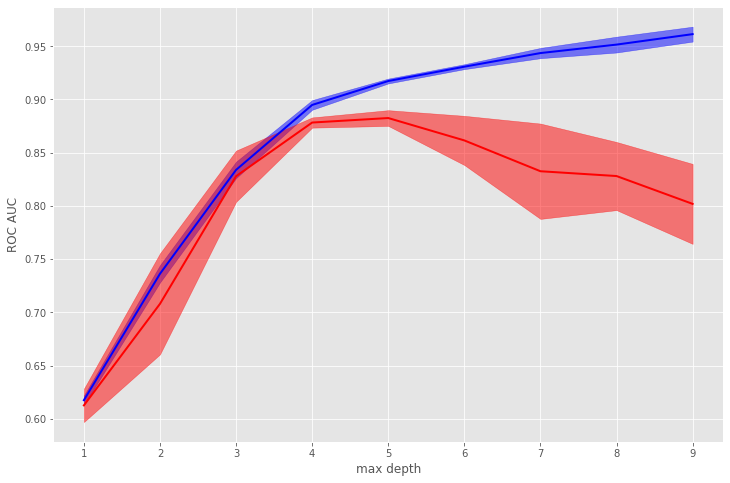

In [44]:
train_score_mean = tree_train_scores.mean(axis=1)
train_score_std = tree_train_scores.std(axis=1)
valid_scores_mean = tree_valid_scores.mean(axis=1)
valid_scores_std = tree_valid_scores.std(axis=1)

plt.fill_between(depths, train_score_mean-train_score_std, train_score_mean+train_score_std, color='b',
                 interpolate=True, alpha=0.5,)
plt.fill_between(depths, valid_scores_mean-valid_scores_std, valid_scores_mean+valid_scores_std, color='red', 
                 interpolate=True, alpha=0.5)

plt.plot(depths, train_score_mean, c='blue', lw=2)
plt.plot(depths, valid_scores_mean, c='red', lw=2)

plt.xlabel('max depth')
plt.ylabel('ROC AUC')

### Важность признаков

Возьмем лучшую модель и выведем важность признаков

In [57]:
model = DecisionTreeClassifier(max_depth=5)
model.fit(X,y)
imp = model.feature_importances_
imp

array([0.        , 0.10373634, 0.        , 0.06109602, 0.03093783,
       0.        , 0.29626951, 0.05278311, 0.0069912 , 0.07406361,
       0.00919418, 0.00056396, 0.00740548, 0.11461272, 0.08807839,
       0.        , 0.15426764])

Каждое число соответствует важности признака, который подавался на вход

Для каждого признака (с названием) получите его значение важности

In [72]:
importance = dict(zip(df_preproc.columns,imp))
importance

{'Account Length': 0.0,
 "Int'l Plan": 0.10373634481347344,
 'VMail Plan': 0.0,
 'VMail Message': 0.061096024323734996,
 'Day Mins': 0.030937830972801415,
 'Day Calls': 0.0,
 'Day Charge': 0.2962695087744273,
 'Eve Mins': 0.052783110637491165,
 'Eve Calls': 0.006991200738999859,
 'Eve Charge': 0.07406360536937984,
 'Night Mins': 0.009194181347256455,
 'Night Calls': 0.0005639642801952935,
 'Night Charge': 0.007405484797062239,
 'Intl Mins': 0.11461271677734387,
 'Intl Calls': 0.08807839039513148,
 'Intl Charge': 0.0,
 'CustServ Calls': 0.15426763677270275}

## Бэггинг над деревьями

In [74]:
from sklearn.ensemble import BaggingClassifier

In [83]:
model = BaggingClassifier(DecisionTreeClassifier(), 
                          n_estimators=100, random_state=123)

In [84]:
bag_train_scores, bag_valid_scores = validation_curve(model, X, y, 
                                      param_name='base_estimator__max_depth', 
                                      param_range=depths, 
                 scoring='roc_auc', cv=cv, n_jobs=-1)

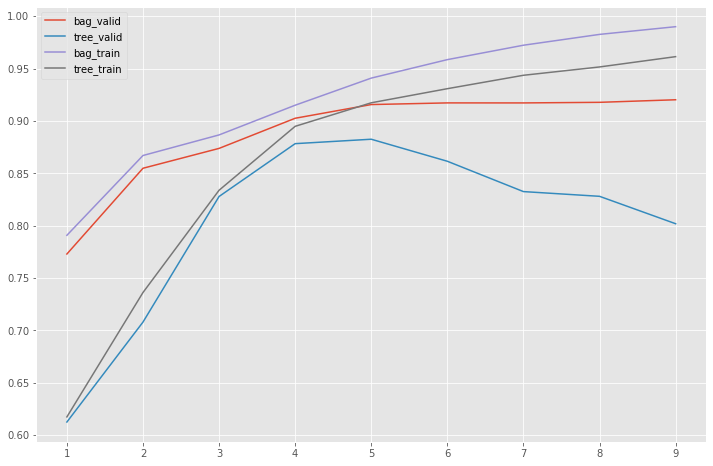

In [85]:
plt.plot(depths, bag_valid_scores.mean(axis=1), label='bag_valid')
plt.plot(depths, tree_valid_scores.mean(axis=1), label='tree_valid')
plt.legend()
plt.plot(depths, bag_train_scores.mean(axis=1), label='bag_train')
plt.plot(depths, tree_train_scores.mean(axis=1), label='tree_train')
plt.legend()

## Случайных лес

In [86]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
model = RandomForestClassifier(random_state=123, n_estimators=50, 
                               n_jobs=-1)

In [ ]:
_, forest_valid_scores = validation_curve(model, X, y, 
                                         param_name='max_depth', 
                                         param_range=depths, 
                 scoring='roc_auc', cv=cv, n_jobs=1)

In [ ]:
plt.plot(depths, bag_valid_scores.mean(axis=1), label='bag')
plt.plot(depths, tree_valid_scores.mean(axis=1), label='tree')
plt.plot(depths, forest_valid_scores.mean(axis=1), label='forest')
plt.legend()

## Подбор всех гиперпараметров

Обычно подбирают гиперпараметры целыми группами. Есть несколько способов это делать
* Полный перебор (Grid Search) - явно задаются все возможные значения параметров. Далее перебираются все возможные комбинации этих параметров
* Случайный перебор (Random Search) - для некоотрых параметров задается распределение через функцию распределения. Задается количество случайных комбинаций, которых требуется перебрать.
* "Умный" перебор ([hyperopt](http://hyperopt.github.io/hyperopt/)) - после каждого шага, следующия комбинация выбирается специальным образом, чтобы с одной стороны проверить неисследованные области, а с другой минимизировать функцию потерь. Не всегда работат так хорошо, как звучит.

Мы же попробует случайный поиск. Почему случайный поиск лучше перебора:

<center><img src='https://cdn-images-1.medium.com/max/800/1*ZTlQm_WRcrNqL-nLnx6GJA.png'></center>

In [ ]:
from scipy.stats import randint as randint
from scipy.stats import uniform

try:
    from sklearn.model_selection import GridSearchCV
    from sklearn.model_selection import RandomizedSearchCV
    from sklearn.model_selection import StratifiedKFold
except ImportError:
    from sklearn.cross_validation import GridSearchCV
    from sklearn.cross_validation import RandomizedSearchCV
    from sklearn.cross_validation import StratifiedKFold


RND_SEED = 123

In [ ]:
# Определим пространство поиска

param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': randint(2, 8),
    'min_samples_leaf': randint(5, 10),
    'class_weight': [None, 'balanced']}

# Некоторые параметры мы задали не простым перечислением значений, а 
# с помощью распределений.

# Будем делать 200 запусков поиска
cv = StratifiedKFold(n_splits=5, random_state=123, shuffle=True)

model = DecisionTreeClassifier(random_state=123)
random_search = RandomizedSearchCV(model, param_distributions=param_grid, n_iter=200, n_jobs=-1,
                                   cv=cv, scoring='roc_auc', random_state=123)
# А дальше, просто .fit()
random_search.fit(X, y)

In [ ]:
random_search.best_params_

In [ ]:
random_search.best_score_

In [ ]:
best_model = random_search.best_estimator_

# Практика 2

### Предобработка данных

In [ ]:
df = pd.read_csv('./data/speed-dating-experiment/Speed Dating Data.csv', encoding='latin1')

In [ ]:
df.shape

In [ ]:
df = df.iloc[:, :97]

Рассмотрим нужные признаки по очереди

#### iid
unique subject number, group(wave id gender)

Кажется это идентификатор

In [ ]:
df.iid.nunique()

#### id 

Subject number within wave

Кажется это нам не нужно

In [ ]:
df = df.drop(['id'], axis=1)
df = df.drop(['idg'], axis=1)

#### gender

* Female=0
* Male=1

In [ ]:
df.drop_duplicates(subset=['iid']).gender.value_counts()

#### condtn:
* 1=limited choice
* 2=extensive choice

???

In [ ]:
df.drop_duplicates(subset=['iid']).condtn.value_counts()

In [ ]:
df = df.drop(['condtn'], axis=1)

#### wave

Пока оставим в таблице, но в качестве признака рассматривать не будем

In [ ]:
df.wave.unique()

#### round:

number of people that met in wave

Можно взять в качестве признака..

In [ ]:
df = df.drop(['round'], axis=1)

#### position:
station number where met partner 

#### positin1
station number where started 

Выкидываем

In [ ]:
df = df.drop(['position', 'positin1'], axis=1)

#### order: 		
the number of date that night when met partner


In [ ]:
df = df.drop(['order'], axis=1)

#### partner: 	
partner’s id number the night of event

Это можно удались

#### pid: 		
partner’s iid number
А вот это важно


In [ ]:
df = df.drop(['partner'], axis=1)

##### match		
* 1=yes, 
* 0=no

Наш таргет

#### int_corr:	
correlation between participant’s and partner’s ratings of interests in 		

#### samerace:  	
participant and the partner were the same race. 1= yes, 0=no

Придумали за нас признаки)

#### age_o:		
age of partner
#### race_o:		
race of partner
#### pf_o_att: 	
partner’s stated preference at Time 1 (attr1_1) for all 6 attributes
#### dec_o: 		
decision of partner the night of event
#### attr_o: 		
rating by partner the night of the event, for all 6 attributes

Убираем

In [ ]:
df = df.drop(['age_o', 'race_o', 'pf_o_att', 
              'pf_o_sin', 'pf_o_int',
              'pf_o_fun', 'pf_o_amb', 'pf_o_sha',
              'dec_o', 'attr_o', 'sinc_o', 'intel_o', 'fun_o',
              'amb_o', 'shar_o', 'like_o', 'prob_o','met_o'], 
             axis=1)

#### age
оставляем

In [ ]:
df.drop_duplicates(subset=['iid']).age.hist(bins=20)

In [ ]:
df.drop_duplicates('iid').age.isnull().sum()

In [ ]:
df = df.dropna(subset=['age'])

#### field:		
field of study  

#### field_cd: 	
field coded 


In [ ]:
for i, group in df.groupby('field_cd'):
    print('=' * 10)
    print('Field Code {}'.format(i))
    print(group.field.unique())

In [ ]:
df.field_cd.isnull().sum()

In [ ]:
df.loc[:, 'field_cd'] = df.loc[:, 'field_cd'].fillna(19)

In [ ]:
df = df.drop(['field'], axis=1)

Надо же как-то закодировать field_cd!

In [ ]:
## Your code here

#### undergrd:  	
school attended for undergraduate degree

Пока выкинем

In [ ]:
df.undergra.value_counts().head()

In [ ]:
df = df.drop(['undergra'], axis=1)

#### mn_sat: 	
Median SAT score for the undergraduate institution where attended.  			

In [ ]:
df.mn_sat.value_counts().head()

In [ ]:
df.loc[:, 'mn_sat'] = df.loc[:, 'mn_sat'].str.replace(',', '').astype(np.float)

In [ ]:
df.drop_duplicates('iid').mn_sat.hist()

In [ ]:
df.drop_duplicates('iid').mn_sat.isnull().sum()

In [ ]:
# Что будем делать?


#### tuition: 	
Tuition listed for each response to undergrad in Barron’s 25th Edition college profile book.

In [ ]:
df.tuition.value_counts().head()

In [ ]:
df.loc[:, 'tuition'] = df.loc[:, 'tuition'].str.replace(',', '').astype(np.float)

In [ ]:
df.drop_duplicates('iid').tuition.hist()

In [ ]:
df.drop_duplicates('iid').tuition.isnull().sum()

In [ ]:
# Что будем делать?


#### race:
* Black/African American=1
* European/Caucasian-American=2
* Latino/Hispanic American=3
* Asian/Pacific Islander/Asian-American=4
* Native American=5
* Other=6


In [ ]:
# Ну тут вы уже сами знаете как быть


#### imprace:
How important is it to you (on a scale of 1-10) that a person you date be of the same racial/ethnic background?

#### imprelig:
 How important is it to you (on a scale of 1-10) that a person you date be of the same religious background?


In [ ]:
df.drop_duplicates('iid').imprace.isnull().sum()

In [ ]:
df.drop_duplicates('iid').imprelig.isnull().sum()

In [ ]:
# Что делать?

df = df.dropna(subset=['imprelig', 'imprace'])

#### from:
Where are you from originally (before coming to Columbia)? 

#### zipcode:
What was the zip code of the area where you grew up? 

Выкидываем

In [ ]:
df = df.drop(['from', 'zipcode'], axis=1)

#### income

In [ ]:
df.loc[:, 'income'] = df.loc[:, 'income'].str.replace(',', '').astype(np.float)

In [ ]:
df.drop_duplicates('iid').loc[:, 'income'].hist()

In [ ]:
df.drop_duplicates('iid').loc[:, 'income'].isnull().sum()

In [ ]:
df = df.drop(['income'], axis=1)
# df.loc[:, 'income'] = df.loc[:, 'income'].fillna(-999)

#### goal:
    What is your primary goal in participating in this event? 
	Seemed like a fun night out=1
	To meet new people=2
	To get a date=3
	Looking for a serious relationship=4
	To say I did it=5
	Other=6

#### date:
    In general, how frequently do you go on dates? 
	Several times a week=1
	Twice a week=2
	Once a week=3
	Twice a month=4
	Once a month=5
	Several times a year=6
	Almost never=7

#### go out:
    How often do you go out (not necessarily on dates)?
	Several times a week=1
	Twice a week=2
	Once a week=3
	Twice a month=4
	Once a month=5
	Several times a year=6
	Almost never=7

Как бы вы предложили закодировать эти переменные?

In [ ]:
df = df.dropna(subset=['date'])

#### career:
What is your intended career?

#### career_c: 
career coded 

Работаем аналогично field и field_cd

In [ ]:
for i, group in df.groupby('career_c'):
    print('=' * 10)
    print('Career Code {}'.format(i))
    print(group.career.unique())

In [ ]:
df.career_c.isnull().sum()

In [ ]:
df.loc[:, 'career_c'] = df.loc[:, 'career_c'].fillna(18)

In [ ]:
df = df.drop(['career'], axis=1)

In [ ]:
# Теперь это надо закодировать


How interested are you in the following activities, on a scale of 1-10?
    
    sports: Playing sports/ athletics
    tvsports: Watching sports
    excersice: Body building/exercising
    dining: Dining out
    museums: Museums/galleries
    art: Art
    hiking:  Hiking/camping
    gaming: Gaming
    clubbing: Dancing/clubbing
    reading: Reading
    tv: Watching TV
    theater: Theater
    movies: Movies
    concerts: Going to concerts
    music: Music
    shopping: Shopping
    yoga: Yoga/meditation

По большому счету с этими признаками можно придумать много чего.. Например у нас уже есть признак, который считает корреляцию между интересами пар. Пока мы все их выкинем

In [ ]:
df.loc[:, ['sports','tvsports','exercise','dining','museums','art','hiking','gaming',
       'clubbing','reading','tv','theater','movies','concerts','music','shopping','yoga']
      ].isnull().sum()

In [ ]:
df = df.drop(['sports','tvsports','exercise','dining','museums','art','hiking','gaming',
       'clubbing','reading','tv','theater','movies','concerts','music','shopping','yoga'], axis=1)

#### exphappy:
Overall, on a scale of 1-10, how happy do you expect to be with the people you meet 
during the speed-dating event?

#### expnum: 
Out of the 20 people you will meet, how many do you expect will be interested in dating you? 


In [ ]:
df.drop_duplicates('iid').exphappy.isnull().sum()

In [ ]:
df.drop_duplicates('iid').expnum.isnull().sum()

In [ ]:
df = df.drop(['expnum'], axis=1)

### Attr1

We want to know what you look for in the opposite sex. 
Waves 6-9: Please rate the importance of the following attributes in a potential date on a scale of 1-10 (1=not at all important, 10=extremely important):
Waves 1-5, 10-21: You have 100 points to distribute among the following attributes -- give more points to those attributes that are more important in a potential date, and fewer points to those attributes that are less important in a potential date.  Total points must equal 100.

attr1_1 
Attractive

sinc1_1
Sincere

intel1_1
Intelligent

fun1_1
Fun

amb1_1
Ambitious

shar1_1
Has shared interests/hobbies


In [ ]:
feat = ['iid', 'wave', 'attr1_1', 'sinc1_1', 'intel1_1', 'fun1_1', 'amb1_1', 'shar1_1']

In [ ]:
temp = df.drop_duplicates(subset=['iid', 'wave']).loc[:, feat]

In [ ]:
temp.loc[:, 'totalsum'] = temp.iloc[:, 2:].sum(axis=1)

In [ ]:
idx = ((temp.wave < 6) | (temp.wave > 9)) & (temp.totalsum < 99)

In [ ]:
temp.loc[idx, ]

In [ ]:
idx = ((temp.wave >= 6) & (temp.wave <= 9))

In [ ]:
temp.loc[idx, ]

Ну понятно, надо чутка подредактировать исходные признаки и в бой

In [ ]:
df.loc[:, 'temp_totalsum'] = df.loc[:, ['attr1_1', 'sinc1_1', 'intel1_1', 'fun1_1', 'amb1_1', 'shar1_1']].sum(axis=1)

In [ ]:
df.loc[:, ['attr1_1', 'sinc1_1', 'intel1_1', 'fun1_1', 'amb1_1', 'shar1_1']] = \
(df.loc[:, ['attr1_1', 'sinc1_1', 'intel1_1', 'fun1_1', 'amb1_1', 'shar1_1']].T/df.loc[:, 'temp_totalsum'].T).T * 100

Проведите аналогичную работу для признаков `attr2`

### Attr2

In [ ]:
feat = ['iid', 'wave', 'attr2_1', 'sinc2_1', 'intel2_1', 'fun2_1', 'amb2_1', 'shar2_1']

In [ ]:
temp = df.drop_duplicates(subset=['iid', 'wave']).loc[:, feat]

In [ ]:
temp.loc[:, 'totalsum'] = temp.iloc[:, 2:].sum(axis=1)

In [ ]:
idx = ((temp.wave < 6) | (temp.wave > 9)) & (temp.totalsum < 90) & (temp.totalsum != 0)

In [ ]:
temp.loc[idx, ]

In [ ]:
idx = ((temp.wave >= 6) & (temp.wave <= 9))

In [ ]:
temp.loc[idx, ]

In [ ]:
df.loc[:, 'temp_totalsum'] = df.loc[:, ['attr2_1', 'sinc2_1', 'intel2_1', 'fun2_1', 'amb2_1', 'shar2_1']].sum(axis=1)

In [ ]:
df.loc[:, ['attr2_1', 'sinc2_1', 'intel2_1', 'fun2_1', 'amb2_1', 'shar2_1']] = \
(df.loc[:, ['attr2_1', 'sinc2_1', 'intel2_1', 'fun2_1', 'amb2_1', 'shar2_1']].T/df.loc[:, 'temp_totalsum'].T).T * 100

In [ ]:
df = df.drop(['temp_totalsum'], axis=1)

Признаки `attr4` и `attr5` пока выбросим

In [ ]:
for i in [4, 5]:
    feat = ['attr{}_1'.format(i), 'sinc{}_1'.format(i), 
            'intel{}_1'.format(i), 'fun{}_1'.format(i), 
            'amb{}_1'.format(i), 'shar{}_1'.format(i)]
    
    if i != 4:
        feat.remove('shar{}_1'.format(i))
    
    df = df.drop(feat, axis=1)

Теперь создалим таблицу с мужчинами, таблицу с женщинами с сджоиним их

In [ ]:
df = df.drop(['wave'], axis=1)

In [ ]:
df_male = df.query('gender == 1').drop_duplicates(subset=['iid', 'pid'])\
                                 .drop(['gender'], axis=1)\
                                 .dropna()
df_female = df.query('gender == 0').drop_duplicates(subset=['iid'])\
                                   .drop(['gender', 'match', 'int_corr', 'samerace'], axis=1)\
                                   .dropna()
        
df_female.columns = df_female.columns + '_f'

#### Задание

* Объедините два датафрейма с помощью метода `join`
* Выделите предикторы в матрицу `X` (numpy.array), а целевой признак в вектор `y`(numpy.array)
* С помощью метода `train_test_split` разбейте данные на обучаюущю и валидационную выборку

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
# Your Code Here

#### Задание

Сфокусируемся на одном гиперпараметре деревьев решений - максимальной глубине.

Подберите наилучшую глубину `d` дерева с помошью 
* Усредненной оценки качества roc-auc на кросс-валидации при различных `d`

In [ ]:
from sklearn.tree import DecisionTreeClassifier

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import validation_curve

In [ ]:
# Your Code Here

#### Задание

Обучите модель с наилучшей глубиной.

Отсортируйте признаки по важности. Вектор с важностью признаков можно получить с помощью `model.feature_importances_`

In [ ]:
# Your Code Here

#### Задание 
* Получите предсказания на тестовой выборке
* Постройте ROC кривые для обучающей и тестовой выборок

In [ ]:
# Your Code Here

#### Задание
Перейдем к модели случайного леса. Зафиксируем некоторую глубину дерева (можно звять оптимальное с предыдущих заданий).

Сравните качество работы 
* Простого дерева решений
* Бэггинга над 10,20,...,100 деревьями решений
* Случайного леса с 10,20,...,100 деревьями решений

Получите график, у которого по оси X откладывается количество деревьев, а по оси Y - качество классификации.

In [ ]:
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier

In [ ]:
# Your Code Here

#### Задание
* С помощью GridSearchCV или RandomSearchCV подберите наиболее оптимальные параметры для случайного леса.
* Для этих параметров сравните средние результаты по кросс-валидации и качество на контрольной выборке



In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

In [ ]:
# Your Code Here